# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
# 과제 - plot을 위한 numpy import
import numpy as np

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 과제 - testdata 준비
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,      # 조건 1
    download=True,
    transform=transform
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

10000
torch.Size([1, 28, 28]) 7


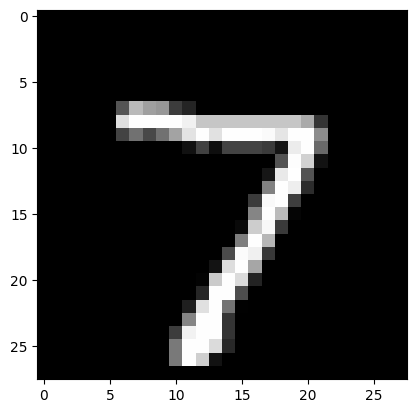

In [ ]:
from matplotlib import pyplot as plt


# print(len(trainset))
# print(trainset[0][0].shape, trainset[0][1])
# plt.imshow(trainset[0][0][0], cmap='gray')

# 과제 - testdata 확인
print(len(testset))
print(testset[0][0].shape, testset[0][1])
plt.imshow(testset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [ ]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

# 과제 - testdata Dataloader 생성
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,  # 배치 사이즈 동일하게
    shuffle=False           # 랜덤하게 섞을 필요 없음 - 훈련 데이터가 아니기 때문
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f'훈련용 데이터: {images.shape, labels.shape}')

# 과제 - TestDataLoader 체크
testDataiter = iter(testloader)
testImages, testLabels = next(testDataiter)
print(f'테스트용 데이터: {testImages.shape, testLabels.shape}')

훈련용 데이터: (torch.Size([64, 1, 28, 28]), torch.Size([64]))
테스트용 데이터: (torch.Size([64, 1, 28, 28]), torch.Size([64]))


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # self.layer3 = nn.Linear(n_dim, 1)

    # 과제 - 기존 Regression => Classification 변경
    # 0 ~ 9 총 10개의 카테고리 중 하나의 클래스를 선택하는 문제로, 분류 문제
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))

    # 과제
    # 마지막 출력층에는 비선형 함수를 넣지 않는 것이 일반적이라고 함
    # 마지막 output에서 ReLU 적용 시 학습/테스트 부분에서 CE 내부 softmax와 중복됨
    # 따라서 마지막 출력에서는 logits만 내서 학습/테스트 부분에서 CE 적용
    x = self.layer3(x)

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [ ]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [ ]:
# 과제 - dataloader에 대한 model의 정확도 측정 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for inputs, labels in dataloader:
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

# 과제 - dataloader에 대한 model 정확도 plot 코드
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)

  # 추가 부분
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.title('Train vs Test Acc')

  plt.legend()

  plt.grid(True)
  plt.show()

Epoch   1 | Loss:  2132.122 | Train Acc:  0.488 | Test Acc:  0.497
Avg Loss:  2.273


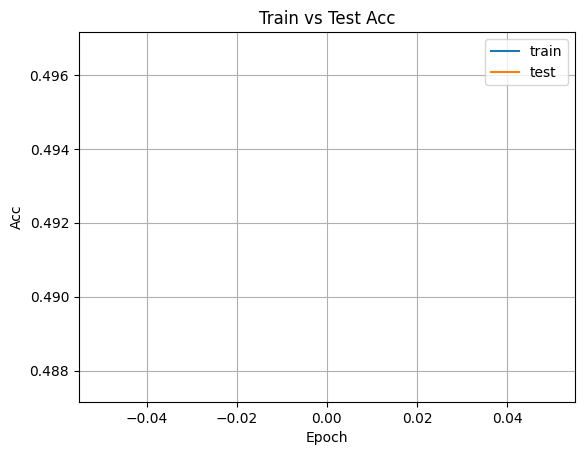

Epoch   2 | Loss:  2057.548 | Train Acc:  0.641 | Test Acc:  0.643
Avg Loss:  2.194


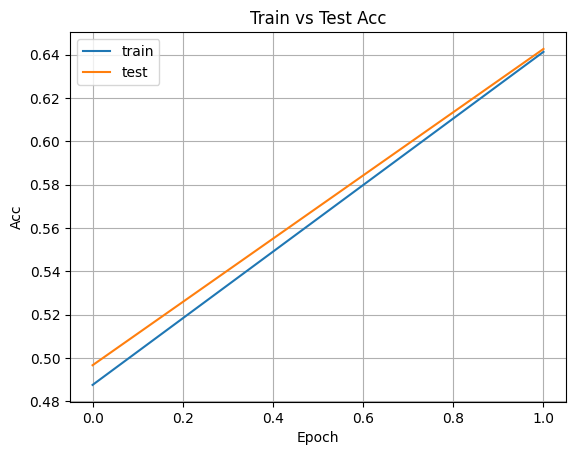

Epoch   3 | Loss:  1939.537 | Train Acc:  0.701 | Test Acc:  0.705
Avg Loss:  2.068


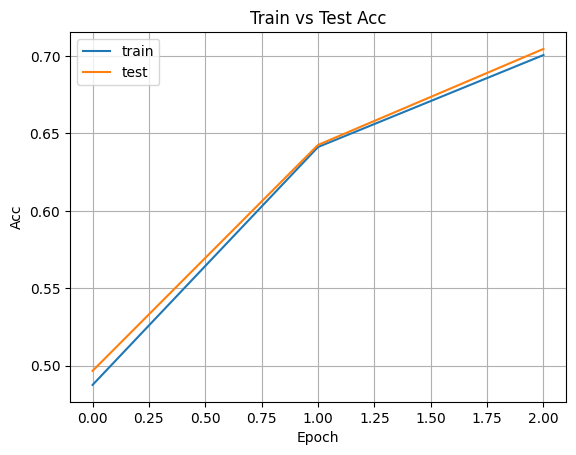

Epoch   4 | Loss:  1739.066 | Train Acc:  0.730 | Test Acc:  0.736
Avg Loss:  1.854


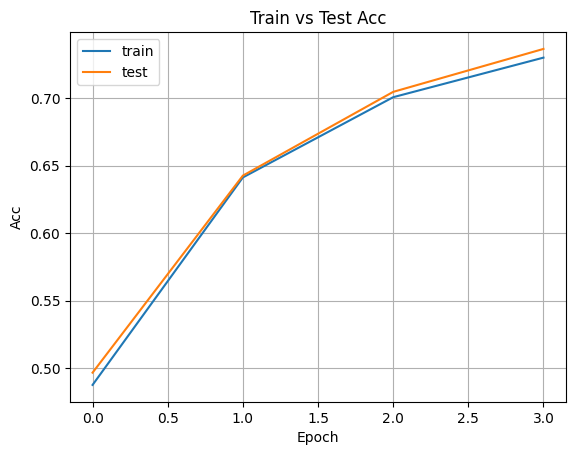

Epoch   5 | Loss:  1447.637 | Train Acc:  0.759 | Test Acc:  0.769
Avg Loss:  1.543


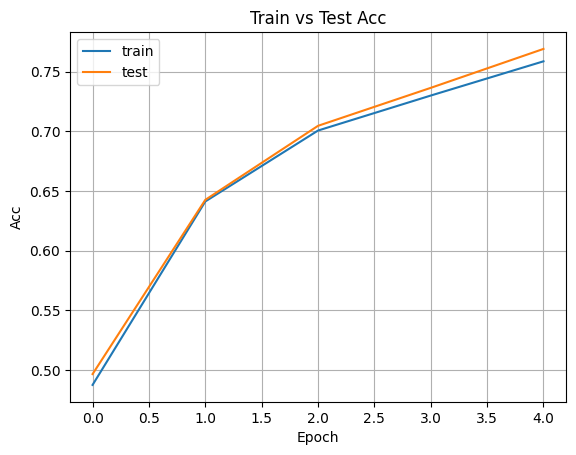

Epoch   6 | Loss:  1142.720 | Train Acc:  0.790 | Test Acc:  0.799
Avg Loss:  1.218


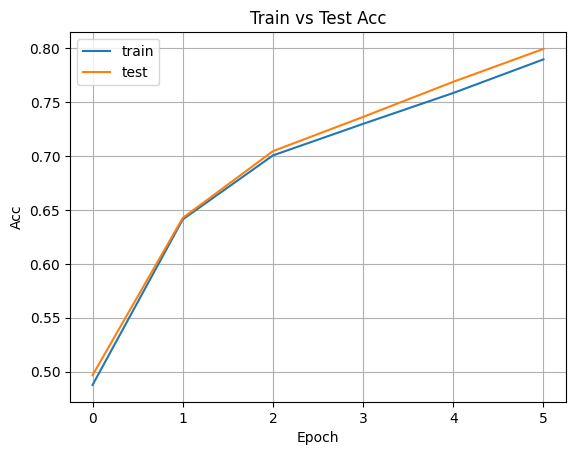

Epoch   7 | Loss:  912.000 | Train Acc:  0.813 | Test Acc:  0.819
Avg Loss:  0.972


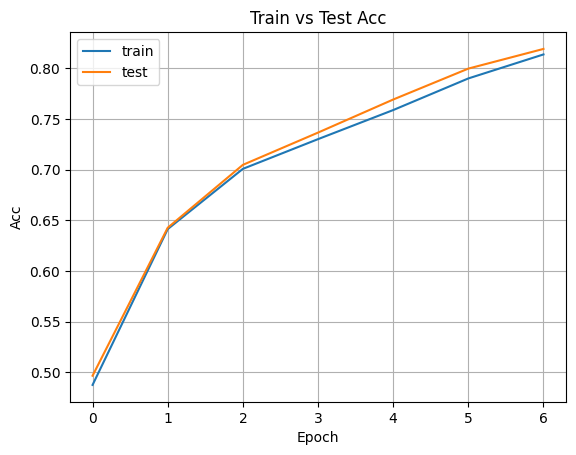

Epoch   8 | Loss:  760.310 | Train Acc:  0.831 | Test Acc:  0.835
Avg Loss:  0.811


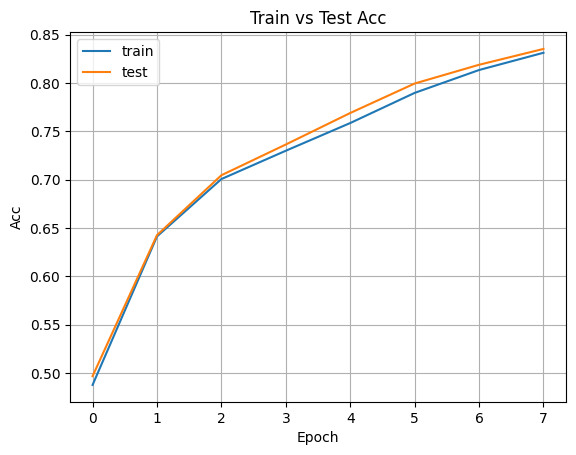

Epoch   9 | Loss:  659.816 | Train Acc:  0.843 | Test Acc:  0.848
Avg Loss:  0.703


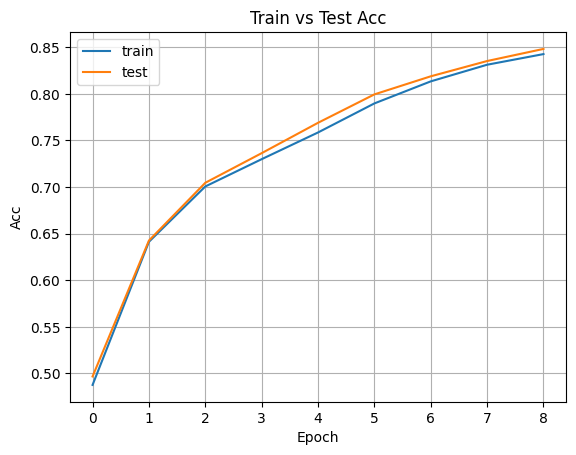

Epoch  10 | Loss:  590.258 | Train Acc:  0.853 | Test Acc:  0.859
Avg Loss:  0.629


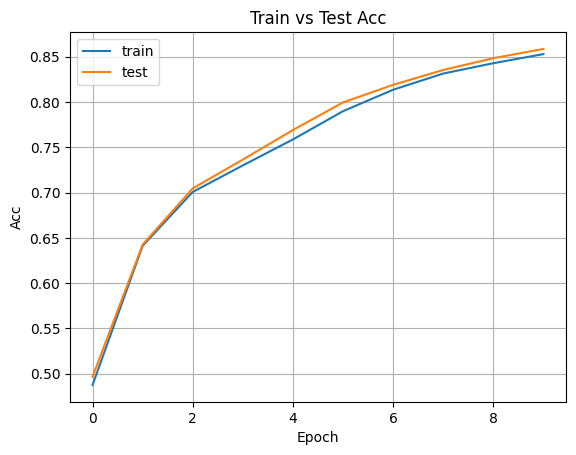

Epoch  11 | Loss:  539.550 | Train Acc:  0.861 | Test Acc:  0.866
Avg Loss:  0.575


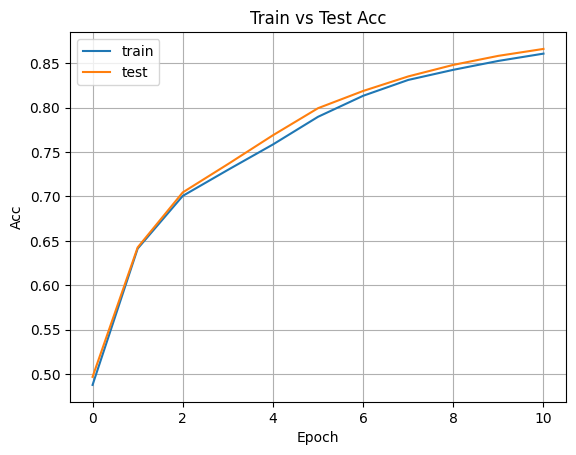

Epoch  12 | Loss:  501.096 | Train Acc:  0.867 | Test Acc:  0.871
Avg Loss:  0.534


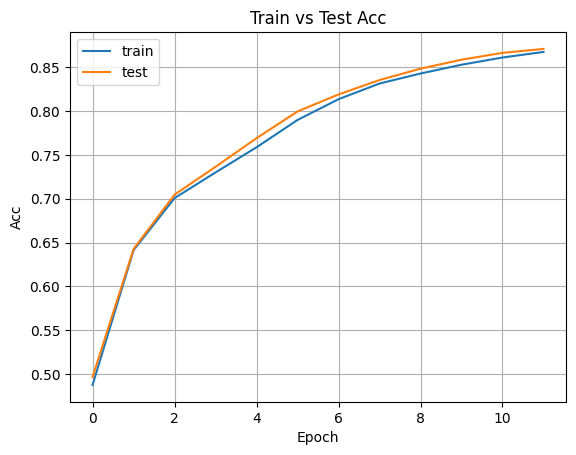

Epoch  13 | Loss:  470.970 | Train Acc:  0.873 | Test Acc:  0.878
Avg Loss:  0.502


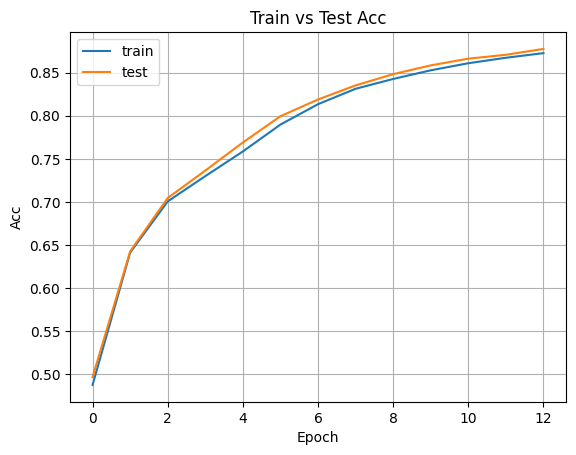

Epoch  14 | Loss:  446.796 | Train Acc:  0.877 | Test Acc:  0.884
Avg Loss:  0.476


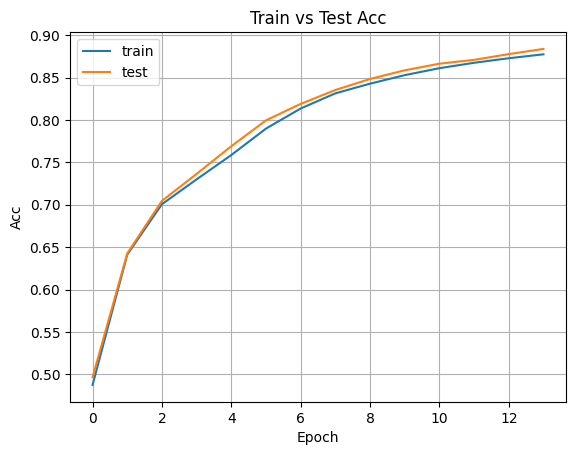

Epoch  15 | Loss:  426.954 | Train Acc:  0.881 | Test Acc:  0.886
Avg Loss:  0.455


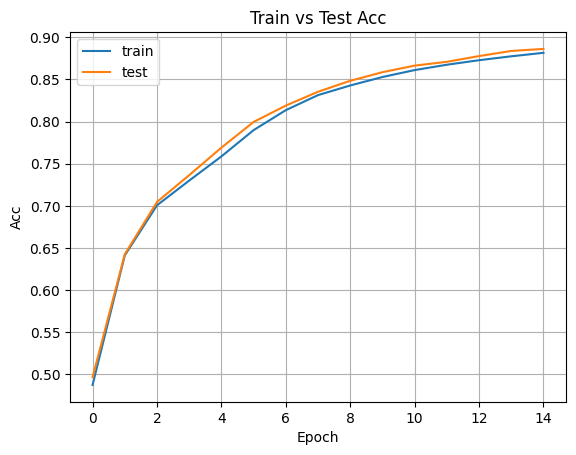

Epoch  16 | Loss:  410.508 | Train Acc:  0.885 | Test Acc:  0.890
Avg Loss:  0.438


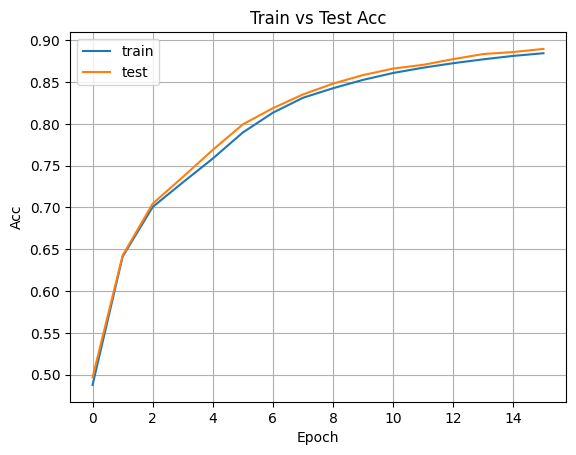

Epoch  17 | Loss:  396.871 | Train Acc:  0.887 | Test Acc:  0.892
Avg Loss:  0.423


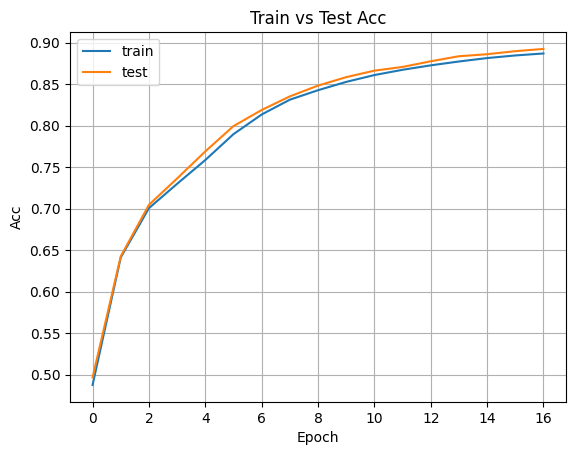

Epoch  18 | Loss:  384.719 | Train Acc:  0.890 | Test Acc:  0.893
Avg Loss:  0.410


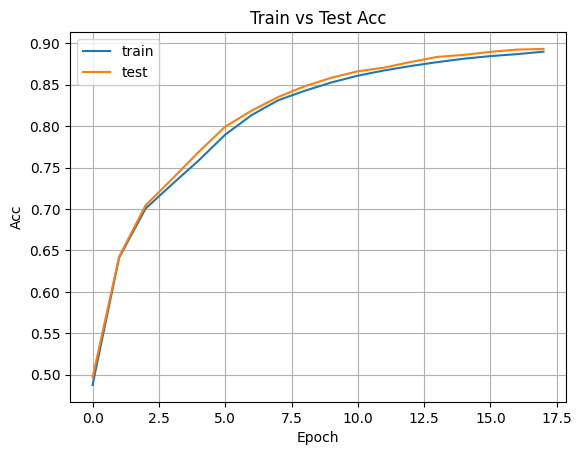

Epoch  19 | Loss:  374.436 | Train Acc:  0.892 | Test Acc:  0.894
Avg Loss:  0.399


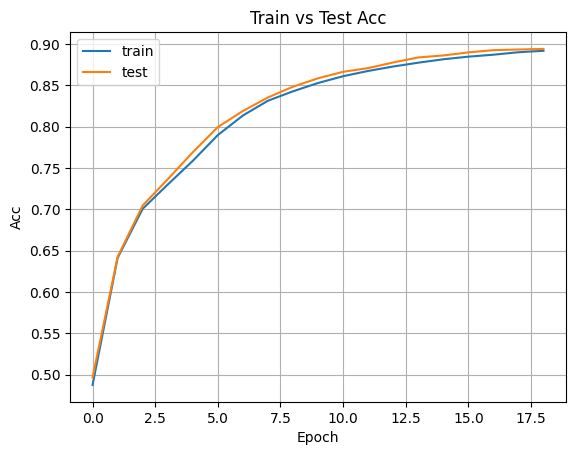

Epoch  20 | Loss:  365.489 | Train Acc:  0.894 | Test Acc:  0.896
Avg Loss:  0.390


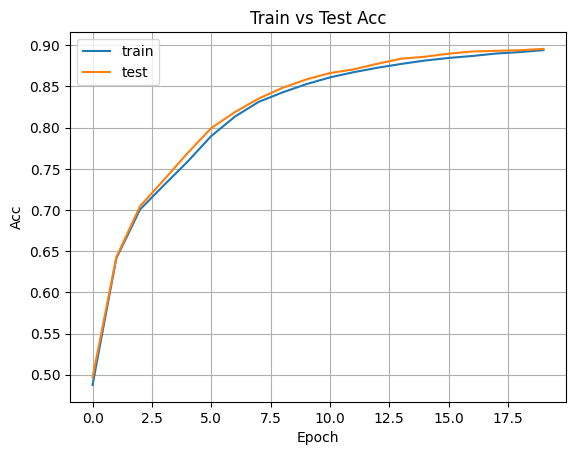

Epoch  21 | Loss:  357.501 | Train Acc:  0.896 | Test Acc:  0.898
Avg Loss:  0.381


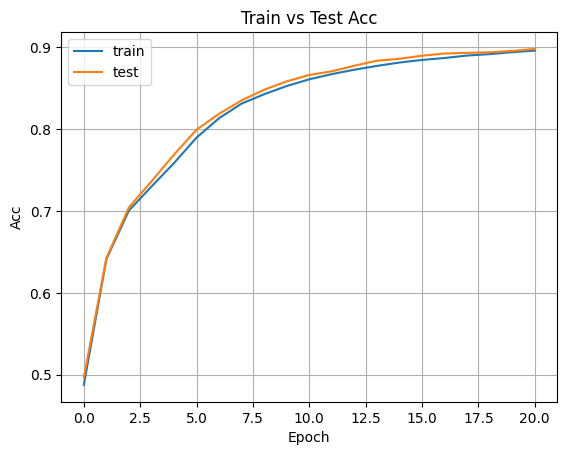

Epoch  22 | Loss:  350.277 | Train Acc:  0.897 | Test Acc:  0.900
Avg Loss:  0.373


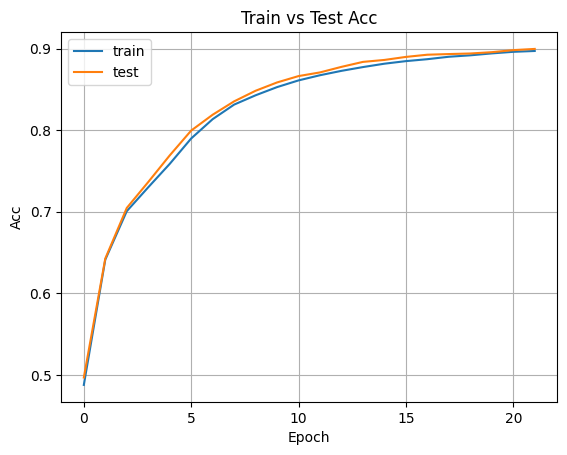

Epoch  23 | Loss:  343.953 | Train Acc:  0.899 | Test Acc:  0.901
Avg Loss:  0.367


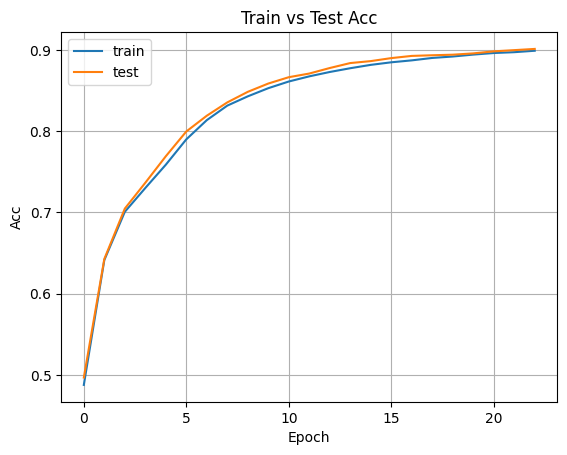

Epoch  24 | Loss:  337.864 | Train Acc:  0.900 | Test Acc:  0.902
Avg Loss:  0.360


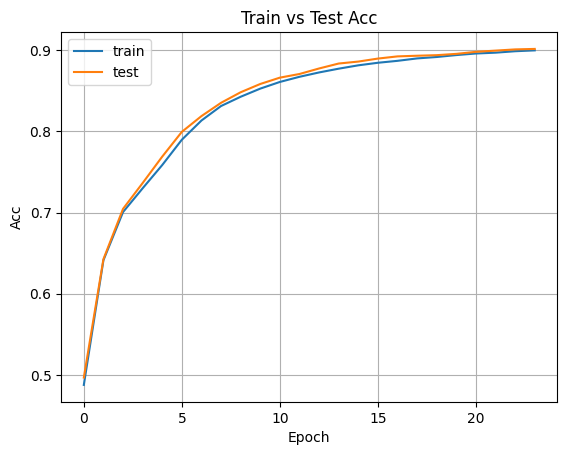

Epoch  25 | Loss:  332.699 | Train Acc:  0.901 | Test Acc:  0.903
Avg Loss:  0.355


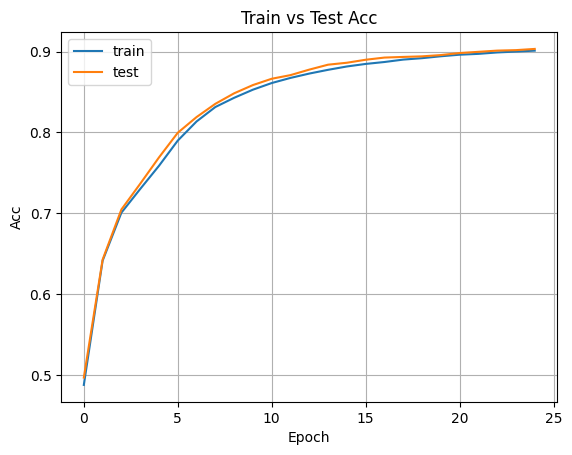

Epoch  26 | Loss:  327.669 | Train Acc:  0.902 | Test Acc:  0.905
Avg Loss:  0.349


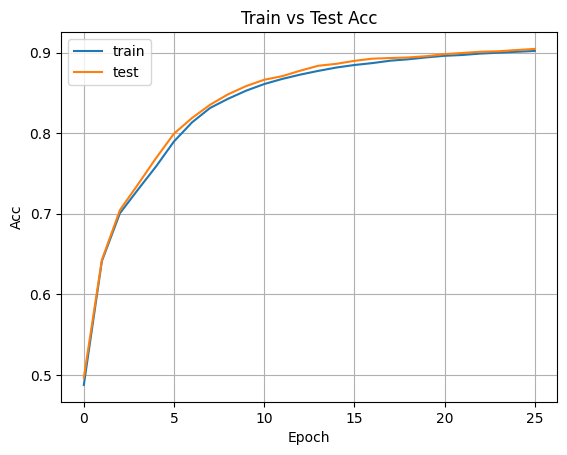

Epoch  27 | Loss:  322.860 | Train Acc:  0.904 | Test Acc:  0.905
Avg Loss:  0.344


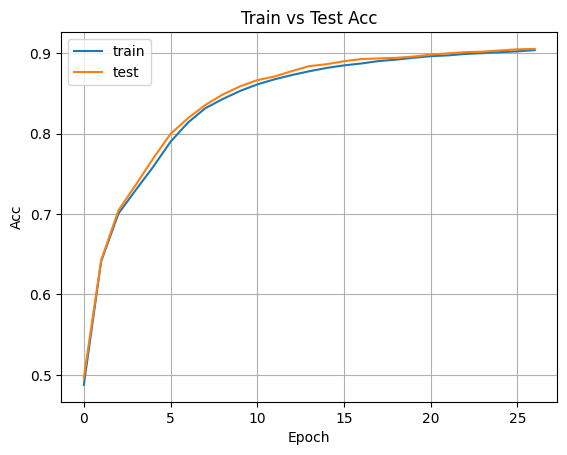

Epoch  28 | Loss:  318.878 | Train Acc:  0.905 | Test Acc:  0.907
Avg Loss:  0.340


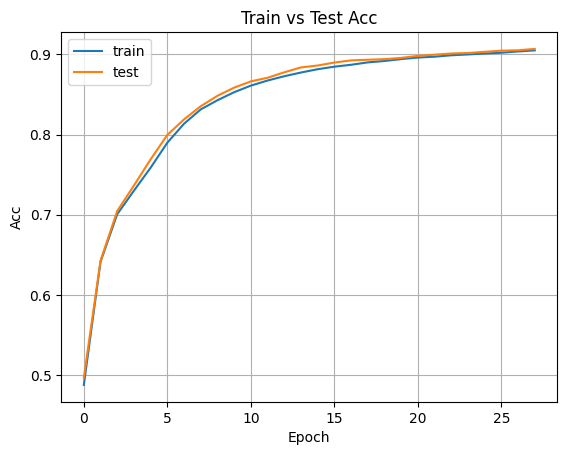

Epoch  29 | Loss:  314.605 | Train Acc:  0.906 | Test Acc:  0.908
Avg Loss:  0.335


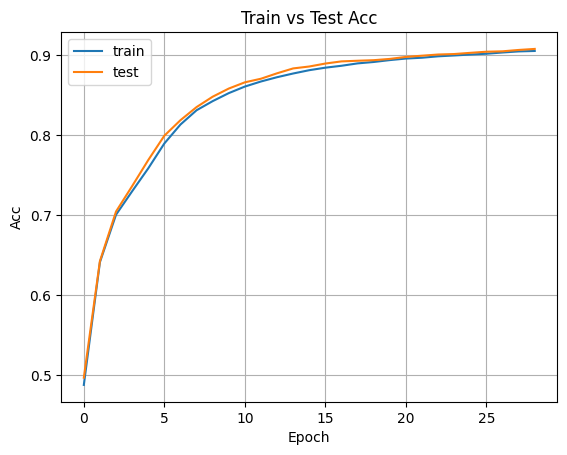

Epoch  30 | Loss:  310.867 | Train Acc:  0.907 | Test Acc:  0.908
Avg Loss:  0.331


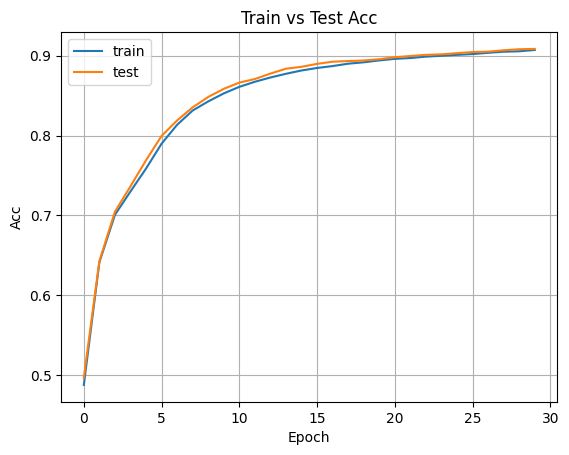

Epoch  31 | Loss:  307.197 | Train Acc:  0.908 | Test Acc:  0.908
Avg Loss:  0.328


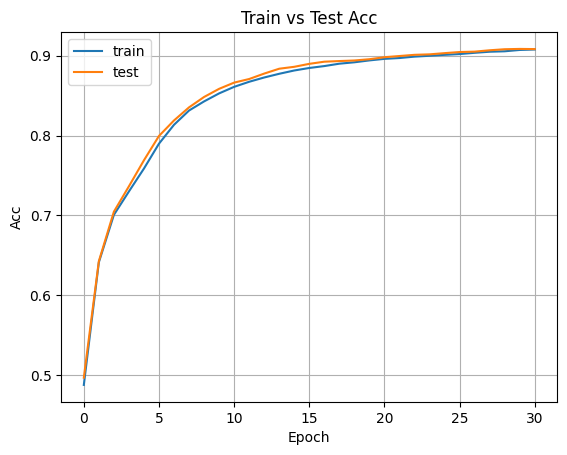

Epoch  32 | Loss:  303.712 | Train Acc:  0.909 | Test Acc:  0.911
Avg Loss:  0.324


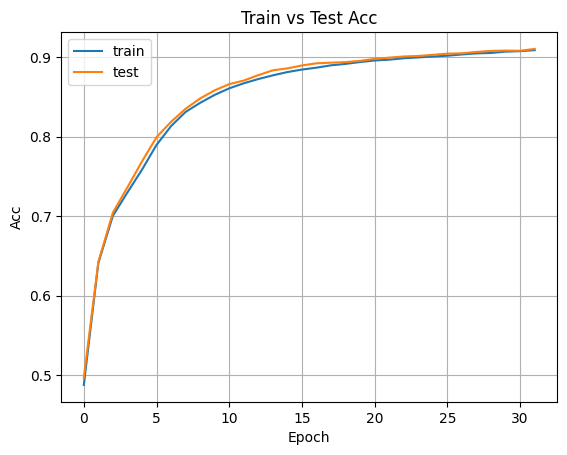

Epoch  33 | Loss:  300.435 | Train Acc:  0.910 | Test Acc:  0.911
Avg Loss:  0.320


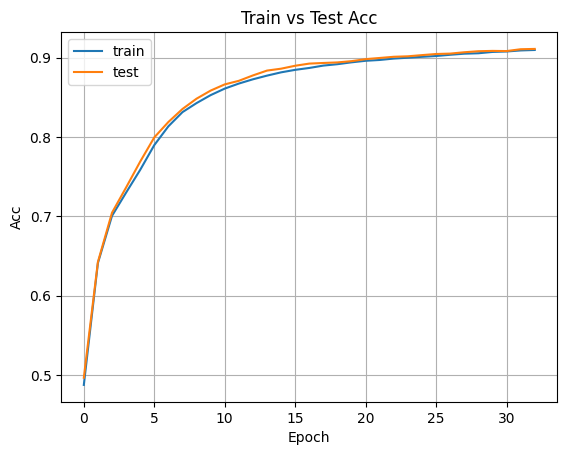

Epoch  34 | Loss:  297.335 | Train Acc:  0.911 | Test Acc:  0.912
Avg Loss:  0.317


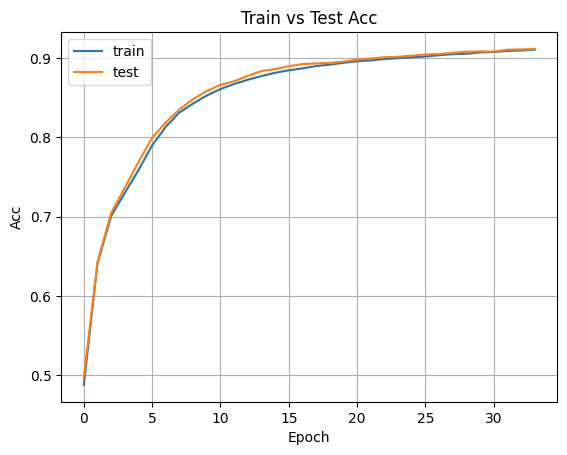

Epoch  35 | Loss:  294.071 | Train Acc:  0.911 | Test Acc:  0.913
Avg Loss:  0.314


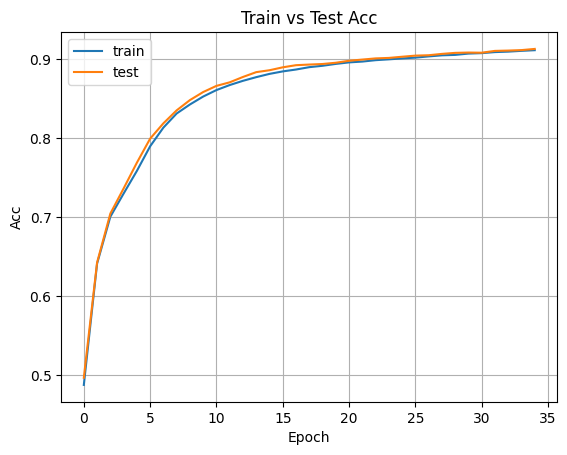

Epoch  36 | Loss:  291.370 | Train Acc:  0.912 | Test Acc:  0.914
Avg Loss:  0.311


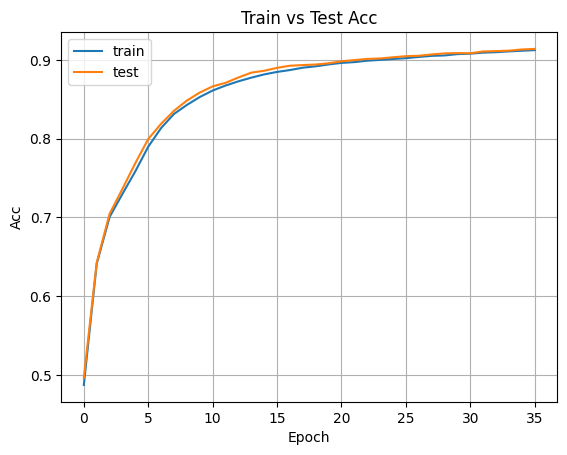

Epoch  37 | Loss:  288.477 | Train Acc:  0.913 | Test Acc:  0.915
Avg Loss:  0.308


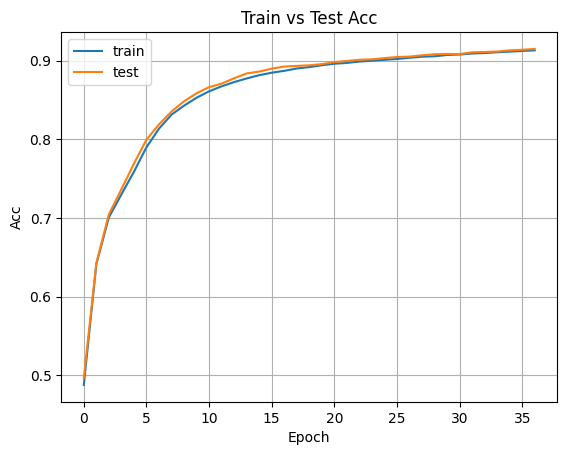

Epoch  38 | Loss:  285.717 | Train Acc:  0.914 | Test Acc:  0.916
Avg Loss:  0.305


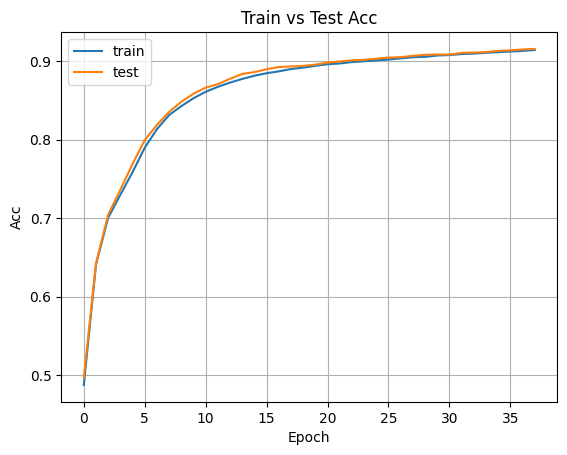

Epoch  39 | Loss:  283.178 | Train Acc:  0.915 | Test Acc:  0.917
Avg Loss:  0.302


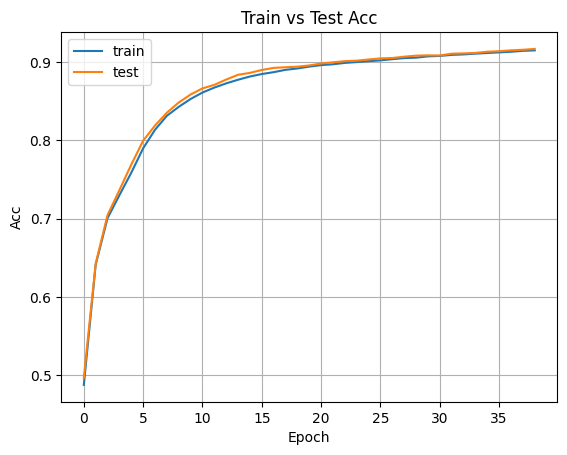

Epoch  40 | Loss:  280.514 | Train Acc:  0.915 | Test Acc:  0.918
Avg Loss:  0.299


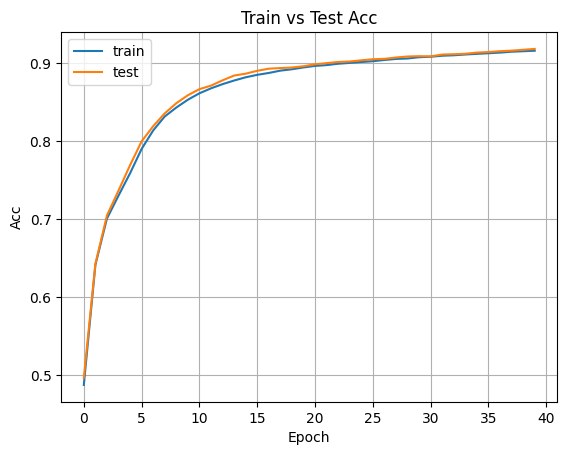

Epoch  41 | Loss:  277.932 | Train Acc:  0.916 | Test Acc:  0.918
Avg Loss:  0.296


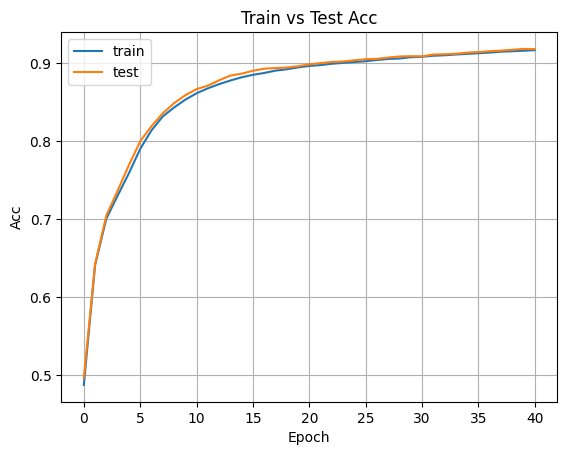

Epoch  42 | Loss:  275.525 | Train Acc:  0.918 | Test Acc:  0.919
Avg Loss:  0.294


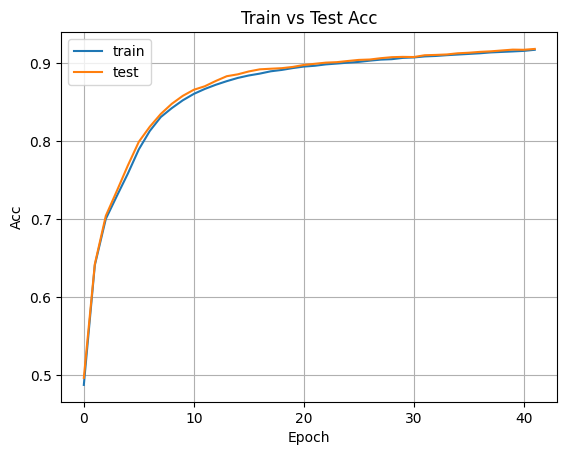

Epoch  43 | Loss:  273.227 | Train Acc:  0.918 | Test Acc:  0.919
Avg Loss:  0.291


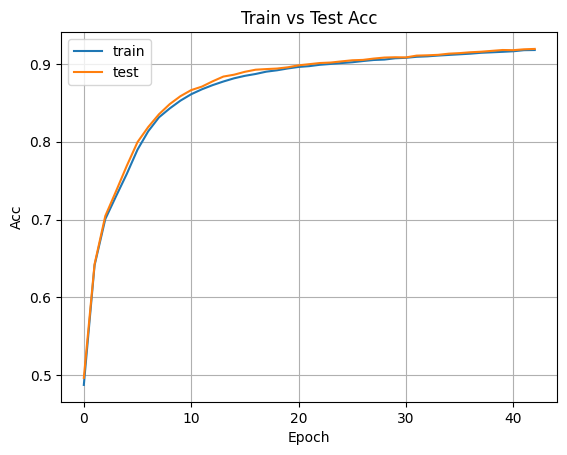

Epoch  44 | Loss:  270.817 | Train Acc:  0.918 | Test Acc:  0.920
Avg Loss:  0.289


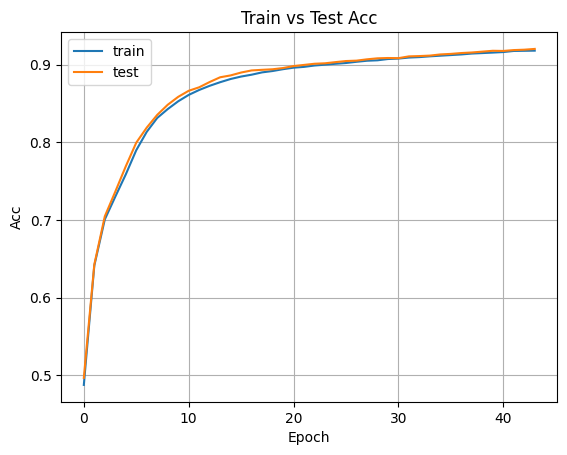

Epoch  45 | Loss:  268.708 | Train Acc:  0.919 | Test Acc:  0.921
Avg Loss:  0.286


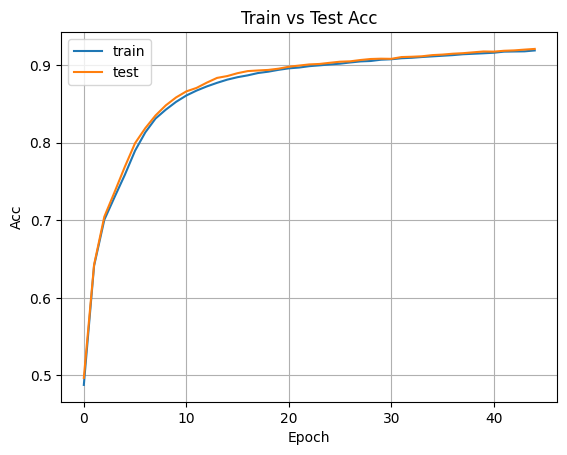

Epoch  46 | Loss:  266.340 | Train Acc:  0.920 | Test Acc:  0.921
Avg Loss:  0.284


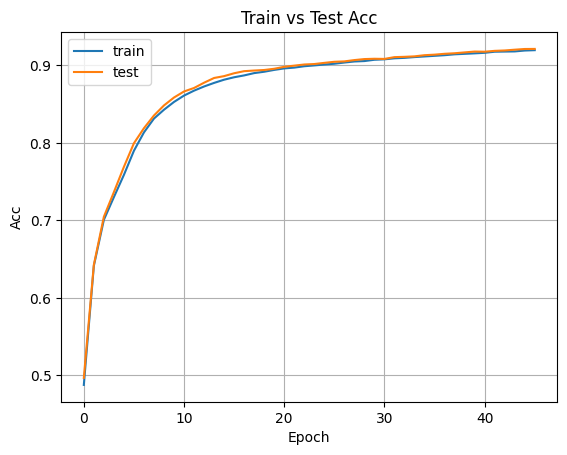

Epoch  47 | Loss:  264.207 | Train Acc:  0.920 | Test Acc:  0.922
Avg Loss:  0.282


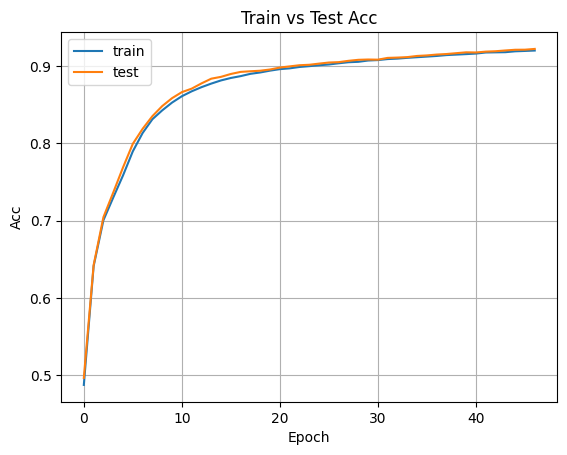

Epoch  48 | Loss:  261.886 | Train Acc:  0.921 | Test Acc:  0.923
Avg Loss:  0.279


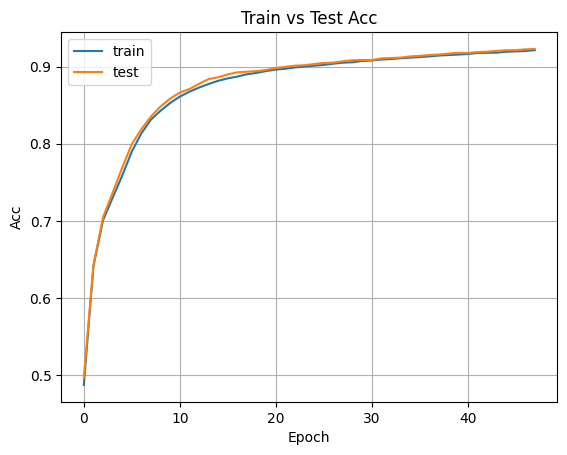

Epoch  49 | Loss:  260.046 | Train Acc:  0.922 | Test Acc:  0.924
Avg Loss:  0.277


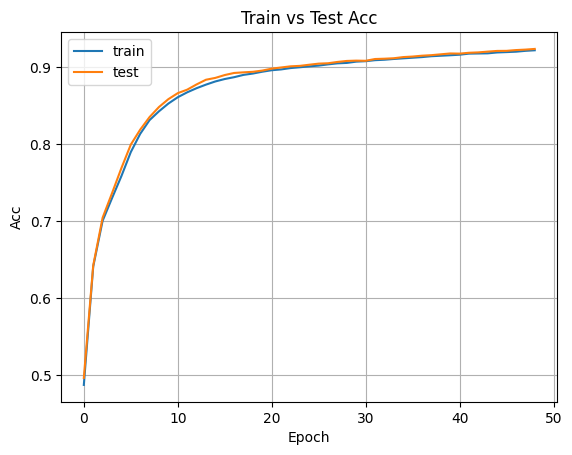

Epoch  50 | Loss:  257.893 | Train Acc:  0.923 | Test Acc:  0.923
Avg Loss:  0.275


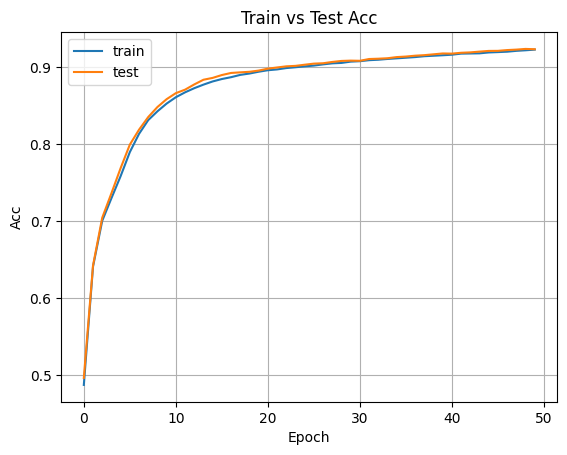

Epoch  51 | Loss:  255.851 | Train Acc:  0.923 | Test Acc:  0.925
Avg Loss:  0.273


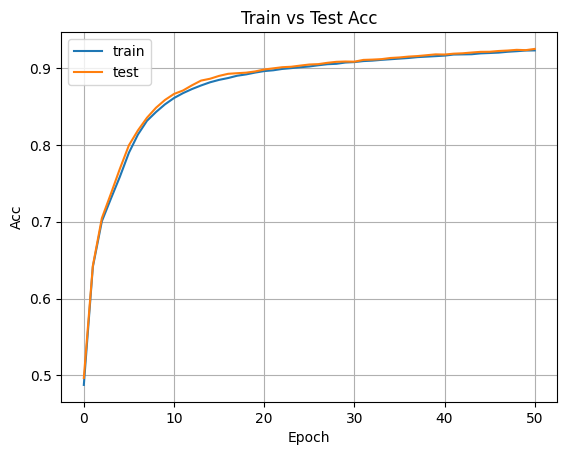

Epoch  52 | Loss:  253.947 | Train Acc:  0.923 | Test Acc:  0.925
Avg Loss:  0.271


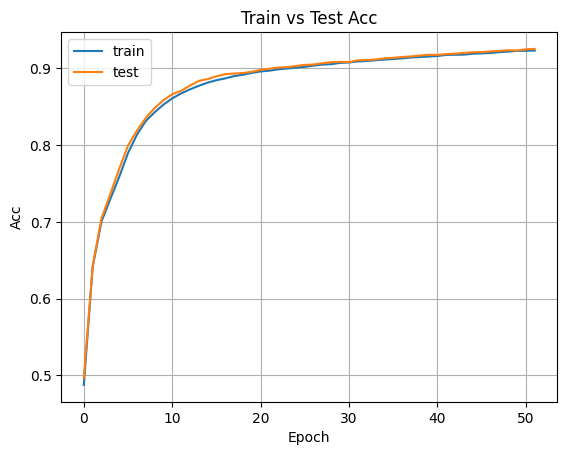

Epoch  53 | Loss:  251.929 | Train Acc:  0.924 | Test Acc:  0.925
Avg Loss:  0.269


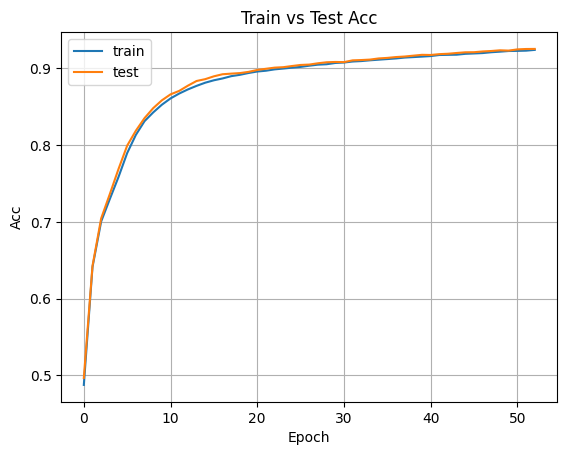

Epoch  54 | Loss:  250.206 | Train Acc:  0.925 | Test Acc:  0.926
Avg Loss:  0.267


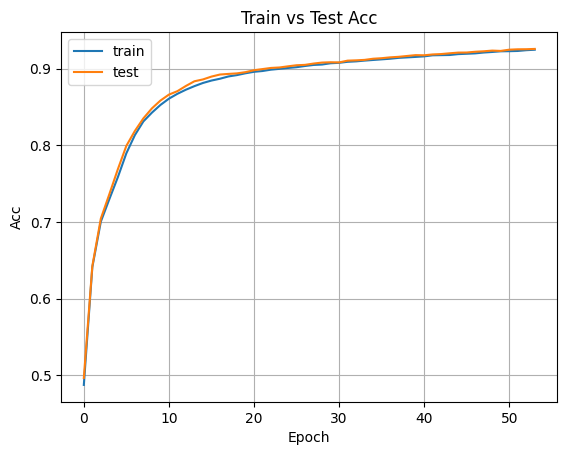

Epoch  55 | Loss:  248.190 | Train Acc:  0.925 | Test Acc:  0.926
Avg Loss:  0.265


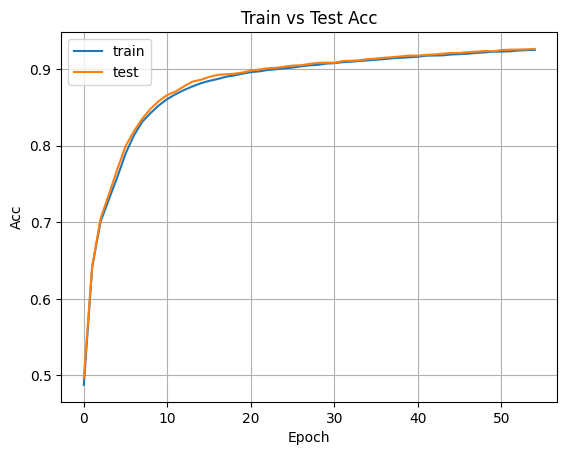

Epoch  56 | Loss:  246.285 | Train Acc:  0.926 | Test Acc:  0.927
Avg Loss:  0.263


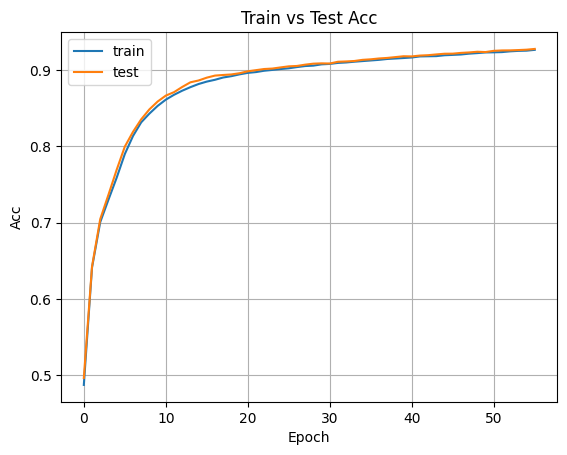

Epoch  57 | Loss:  244.397 | Train Acc:  0.927 | Test Acc:  0.928
Avg Loss:  0.261


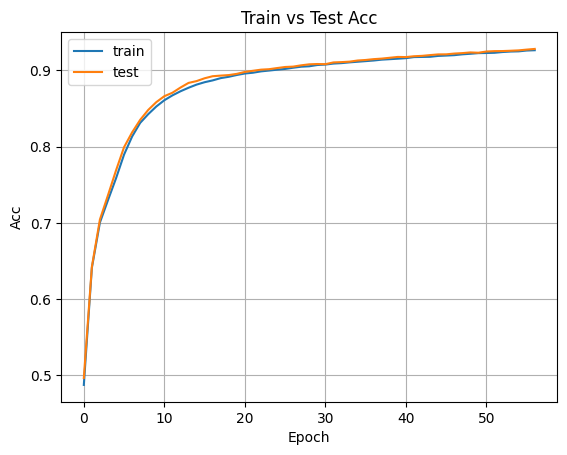

Epoch  58 | Loss:  242.709 | Train Acc:  0.927 | Test Acc:  0.929
Avg Loss:  0.259


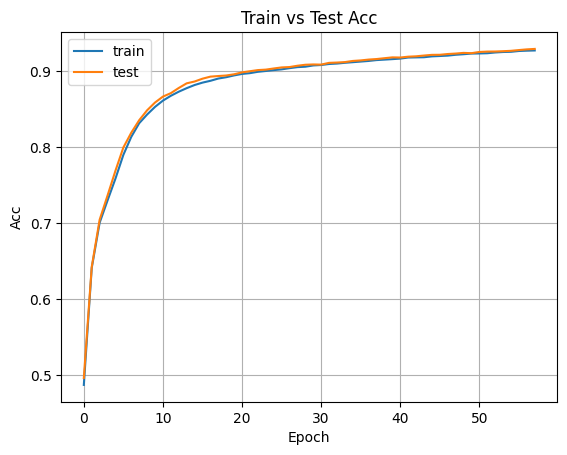

Epoch  59 | Loss:  240.875 | Train Acc:  0.927 | Test Acc:  0.929
Avg Loss:  0.257


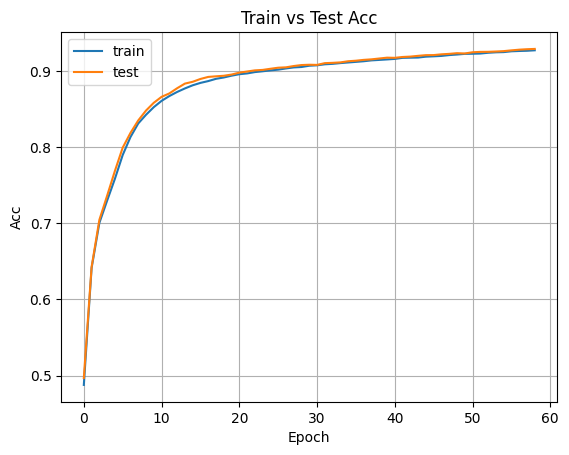

Epoch  60 | Loss:  239.079 | Train Acc:  0.928 | Test Acc:  0.930
Avg Loss:  0.255


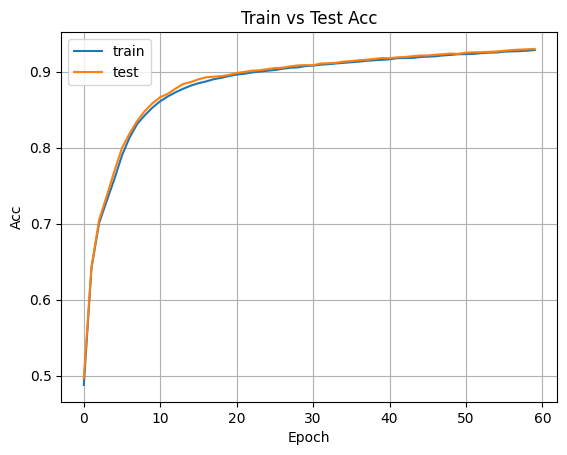

Epoch  61 | Loss:  237.317 | Train Acc:  0.929 | Test Acc:  0.930
Avg Loss:  0.253


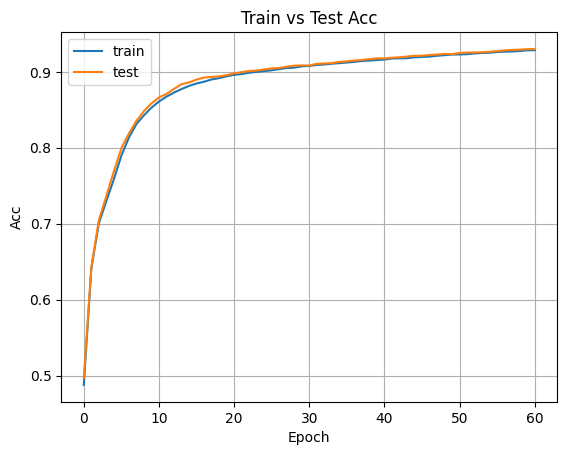

Epoch  62 | Loss:  235.621 | Train Acc:  0.929 | Test Acc:  0.930
Avg Loss:  0.251


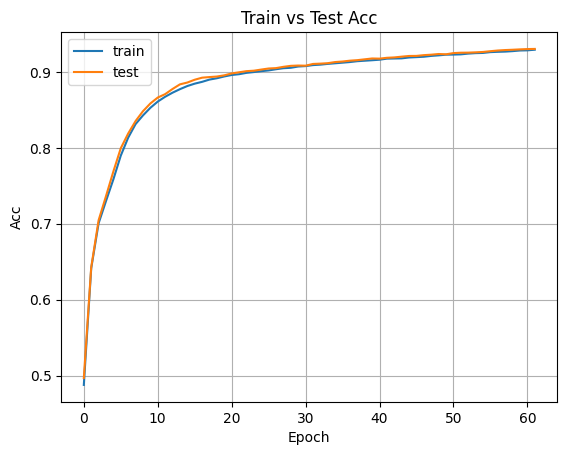

Epoch  63 | Loss:  233.932 | Train Acc:  0.930 | Test Acc:  0.931
Avg Loss:  0.249


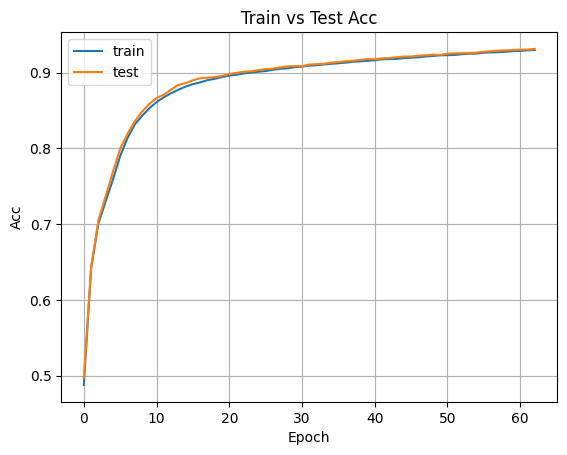

Epoch  64 | Loss:  232.144 | Train Acc:  0.930 | Test Acc:  0.932
Avg Loss:  0.247


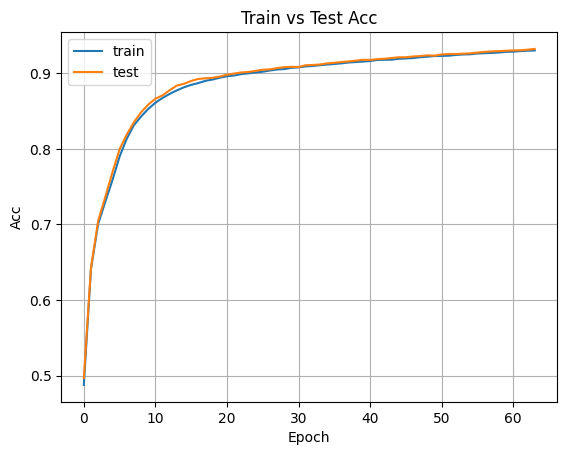

Epoch  65 | Loss:  230.590 | Train Acc:  0.931 | Test Acc:  0.932
Avg Loss:  0.246


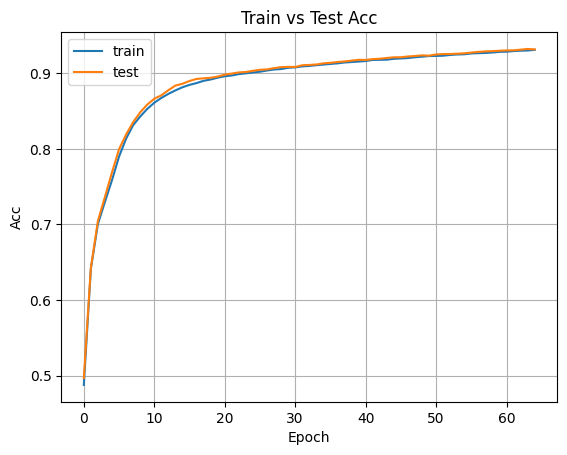

Epoch  66 | Loss:  228.988 | Train Acc:  0.931 | Test Acc:  0.932
Avg Loss:  0.244


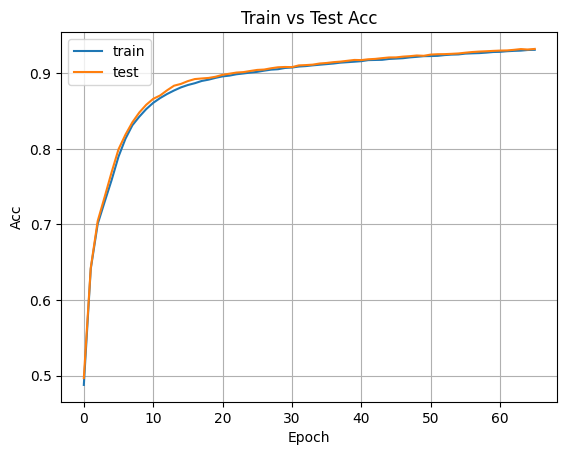

Epoch  67 | Loss:  227.158 | Train Acc:  0.932 | Test Acc:  0.933
Avg Loss:  0.242


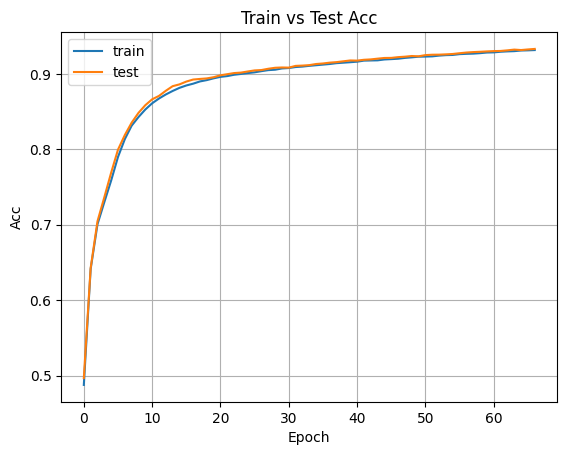

Epoch  68 | Loss:  225.748 | Train Acc:  0.933 | Test Acc:  0.934
Avg Loss:  0.241


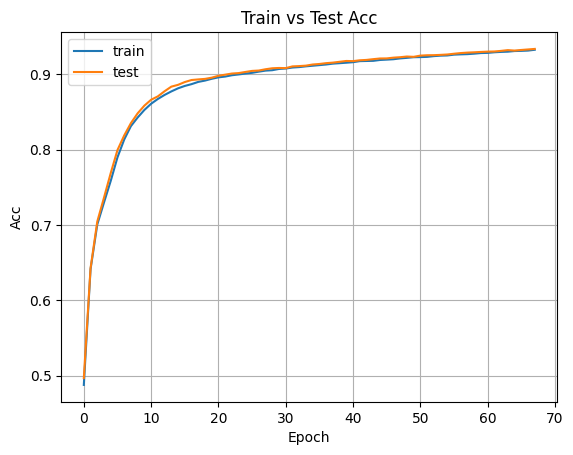

Epoch  69 | Loss:  223.968 | Train Acc:  0.933 | Test Acc:  0.934
Avg Loss:  0.239


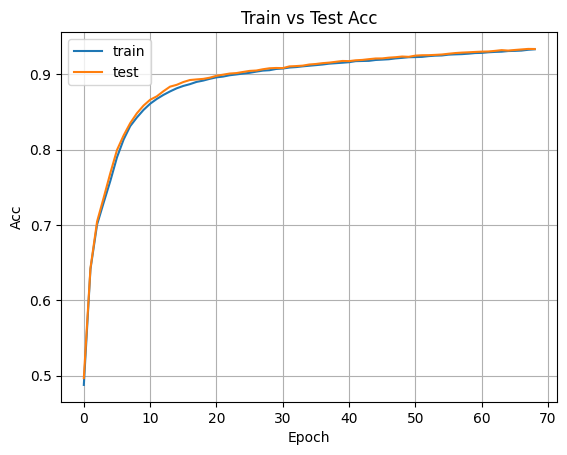

Epoch  70 | Loss:  222.316 | Train Acc:  0.933 | Test Acc:  0.933
Avg Loss:  0.237


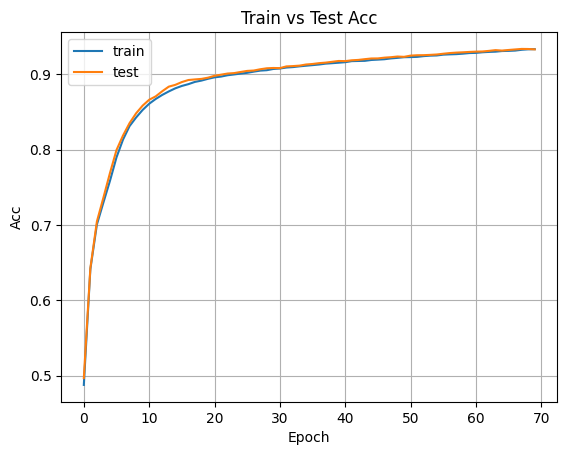

Epoch  71 | Loss:  220.784 | Train Acc:  0.934 | Test Acc:  0.934
Avg Loss:  0.235


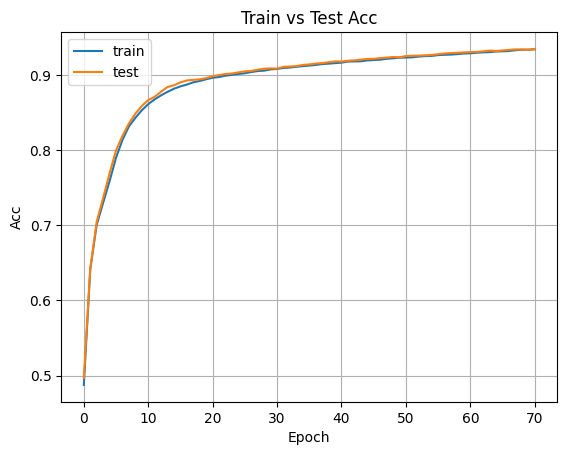

Epoch  72 | Loss:  219.229 | Train Acc:  0.935 | Test Acc:  0.934
Avg Loss:  0.234


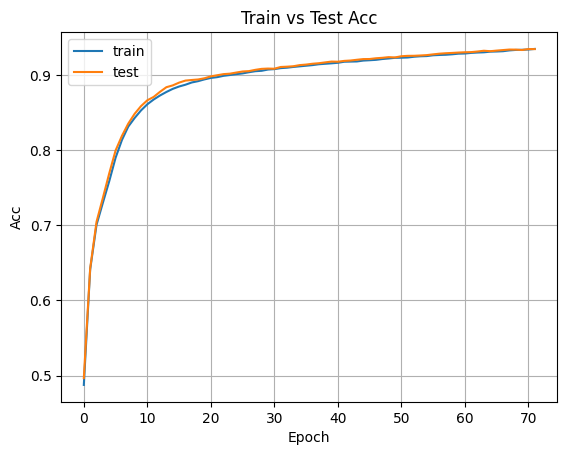

Epoch  73 | Loss:  217.671 | Train Acc:  0.934 | Test Acc:  0.934
Avg Loss:  0.232


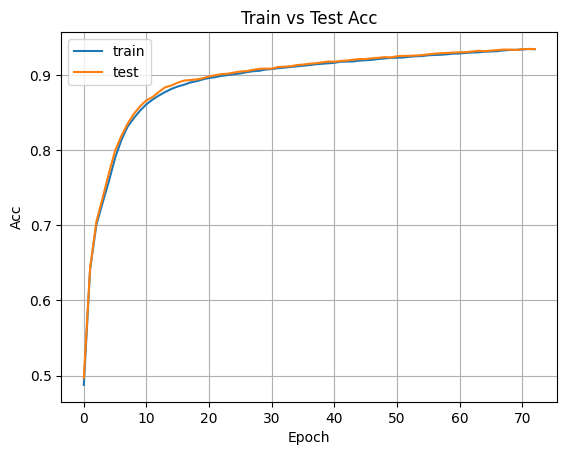

Epoch  74 | Loss:  216.292 | Train Acc:  0.935 | Test Acc:  0.936
Avg Loss:  0.231


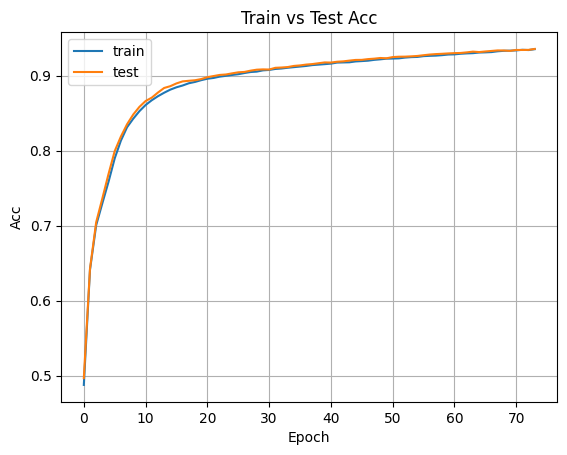

Epoch  75 | Loss:  214.857 | Train Acc:  0.936 | Test Acc:  0.936
Avg Loss:  0.229


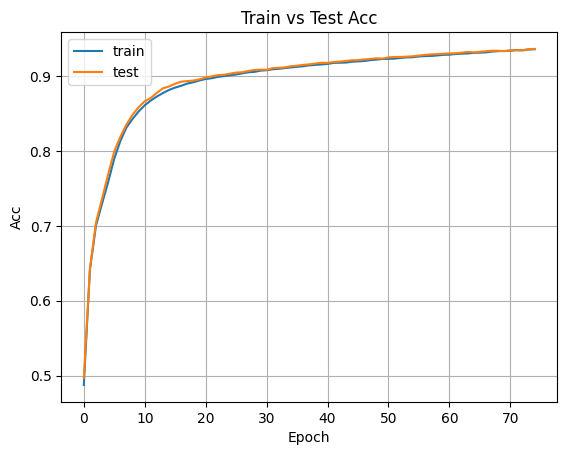

Epoch  76 | Loss:  213.261 | Train Acc:  0.936 | Test Acc:  0.936
Avg Loss:  0.227


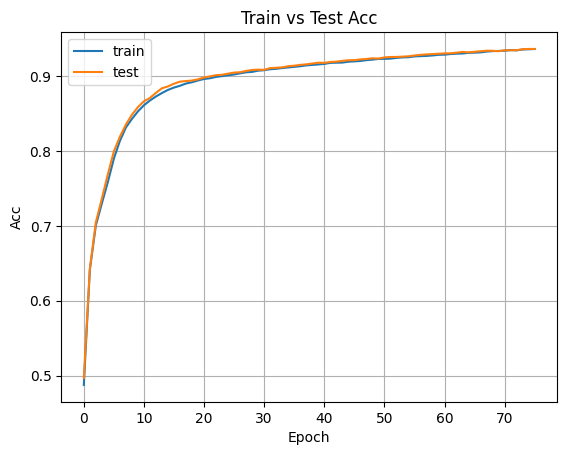

Epoch  77 | Loss:  211.792 | Train Acc:  0.937 | Test Acc:  0.936
Avg Loss:  0.226


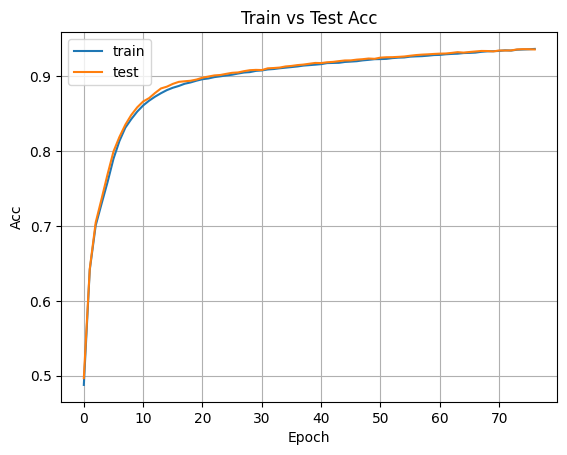

Epoch  78 | Loss:  210.297 | Train Acc:  0.937 | Test Acc:  0.937
Avg Loss:  0.224


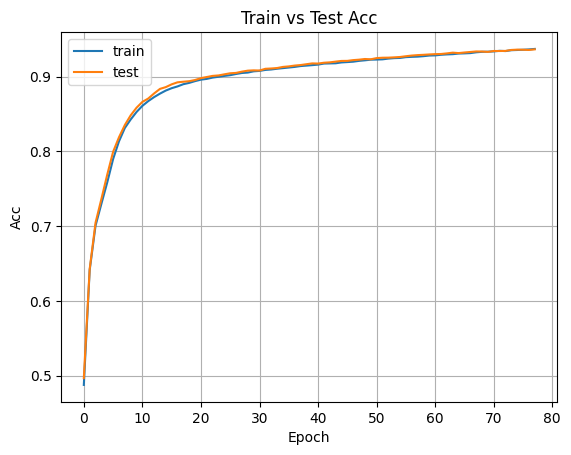

Epoch  79 | Loss:  208.926 | Train Acc:  0.938 | Test Acc:  0.937
Avg Loss:  0.223


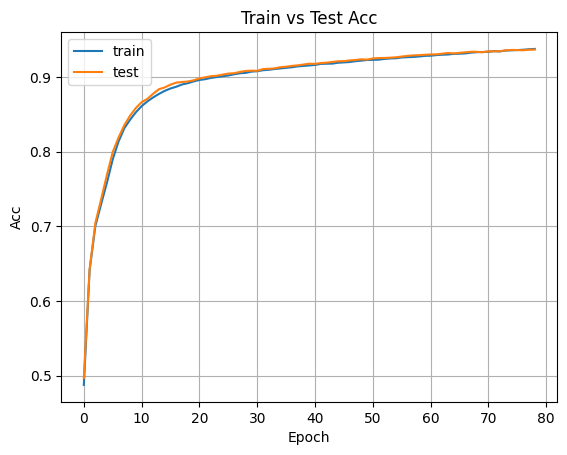

Epoch  80 | Loss:  207.602 | Train Acc:  0.938 | Test Acc:  0.937
Avg Loss:  0.221


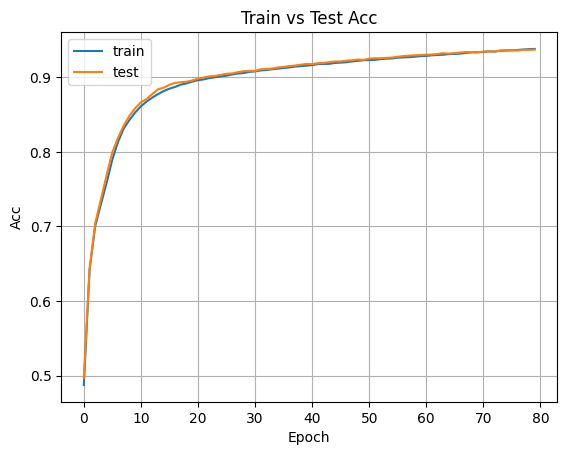

Epoch  81 | Loss:  206.144 | Train Acc:  0.938 | Test Acc:  0.938
Avg Loss:  0.220


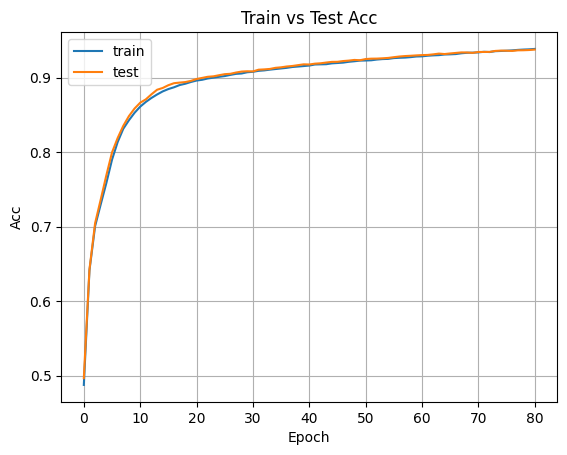

Epoch  82 | Loss:  204.685 | Train Acc:  0.939 | Test Acc:  0.937
Avg Loss:  0.218


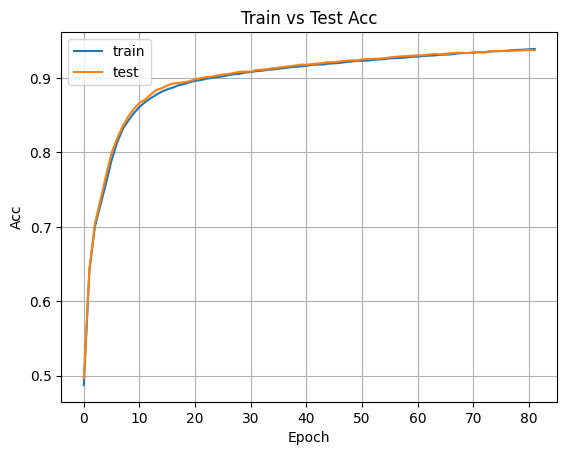

Epoch  83 | Loss:  203.341 | Train Acc:  0.939 | Test Acc:  0.938
Avg Loss:  0.217


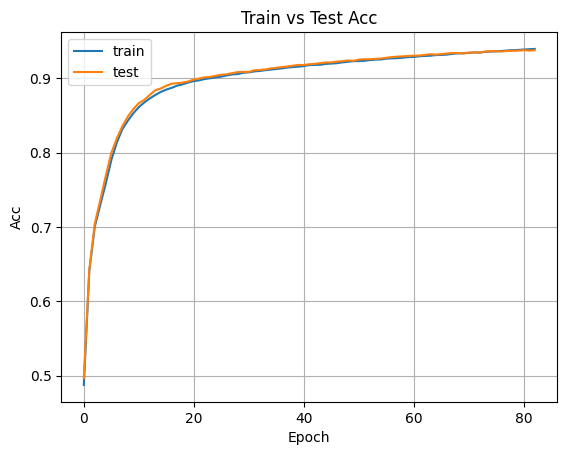

Epoch  84 | Loss:  201.941 | Train Acc:  0.940 | Test Acc:  0.939
Avg Loss:  0.215


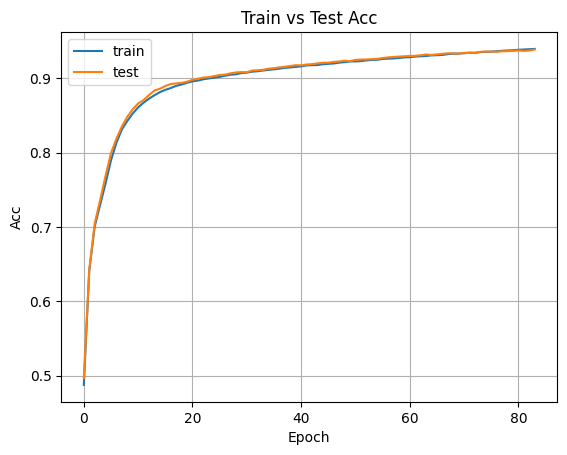

Epoch  85 | Loss:  200.587 | Train Acc:  0.940 | Test Acc:  0.939
Avg Loss:  0.214


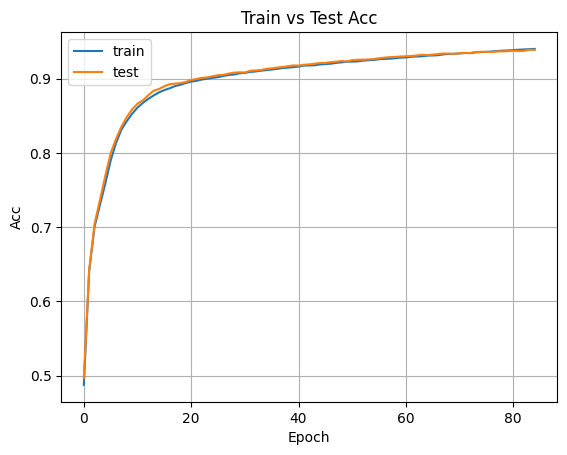

Epoch  86 | Loss:  199.262 | Train Acc:  0.941 | Test Acc:  0.940
Avg Loss:  0.212


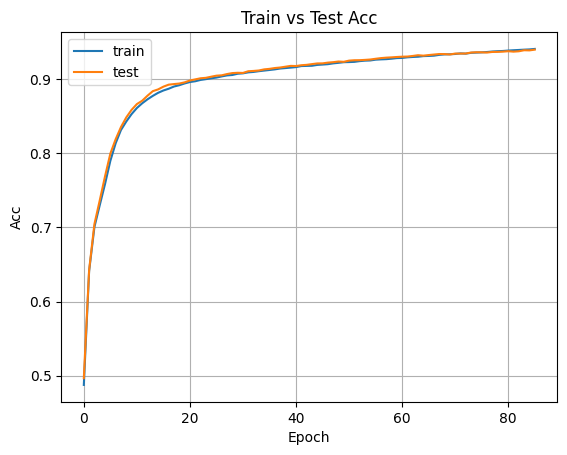

Epoch  87 | Loss:  198.050 | Train Acc:  0.941 | Test Acc:  0.939
Avg Loss:  0.211


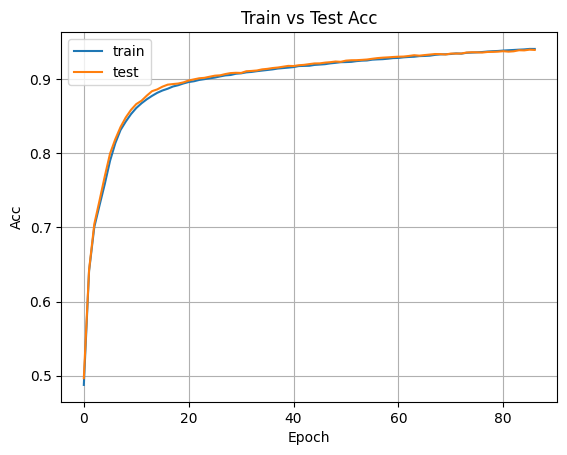

Epoch  88 | Loss:  196.549 | Train Acc:  0.941 | Test Acc:  0.940
Avg Loss:  0.210


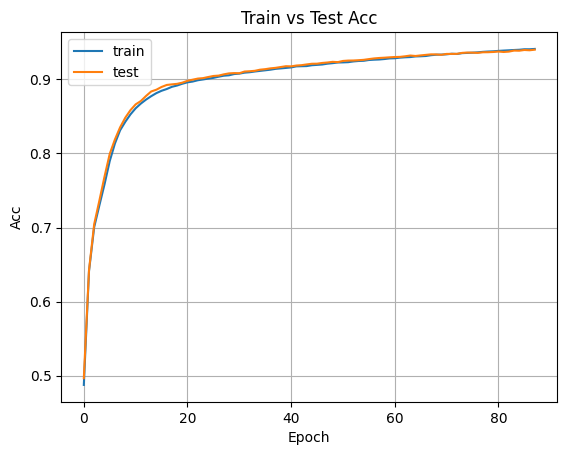

Epoch  89 | Loss:  195.296 | Train Acc:  0.942 | Test Acc:  0.940
Avg Loss:  0.208


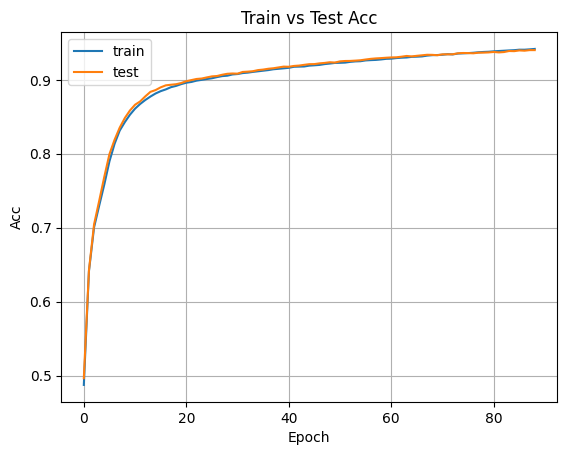

Epoch  90 | Loss:  194.121 | Train Acc:  0.942 | Test Acc:  0.940
Avg Loss:  0.207


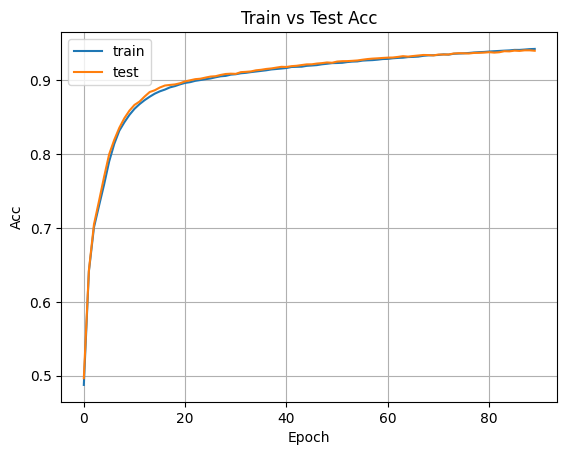

Epoch  91 | Loss:  192.784 | Train Acc:  0.942 | Test Acc:  0.940
Avg Loss:  0.206


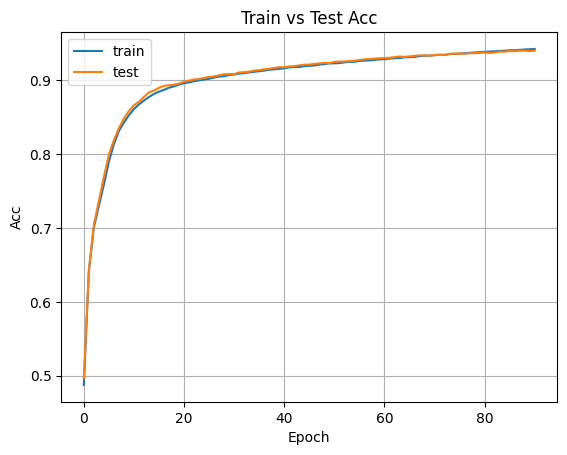

Epoch  92 | Loss:  191.644 | Train Acc:  0.943 | Test Acc:  0.941
Avg Loss:  0.204


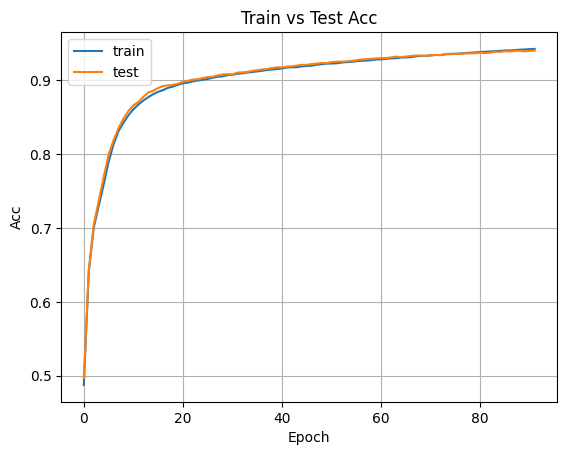

Epoch  93 | Loss:  190.253 | Train Acc:  0.943 | Test Acc:  0.941
Avg Loss:  0.203


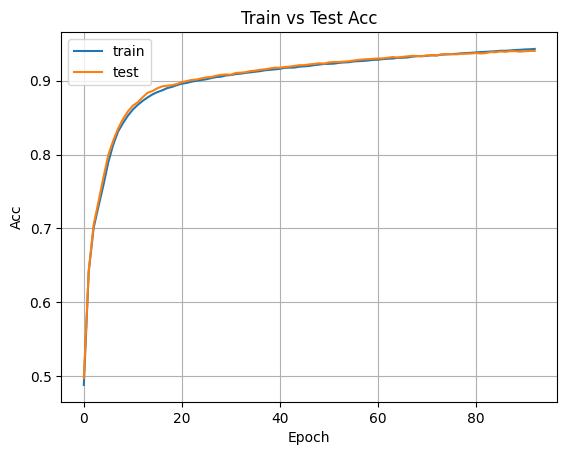

Epoch  94 | Loss:  188.963 | Train Acc:  0.943 | Test Acc:  0.941
Avg Loss:  0.201


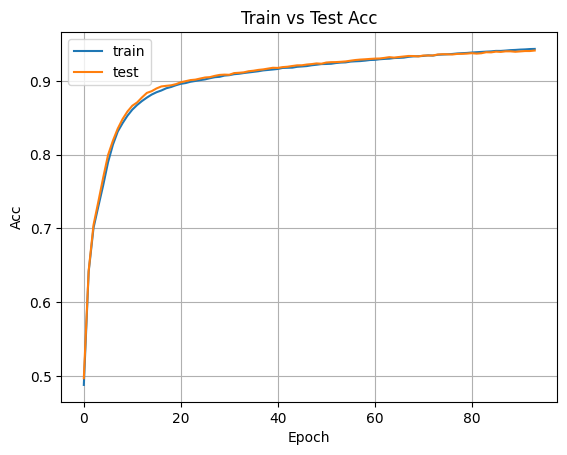

Epoch  95 | Loss:  187.788 | Train Acc:  0.944 | Test Acc:  0.941
Avg Loss:  0.200


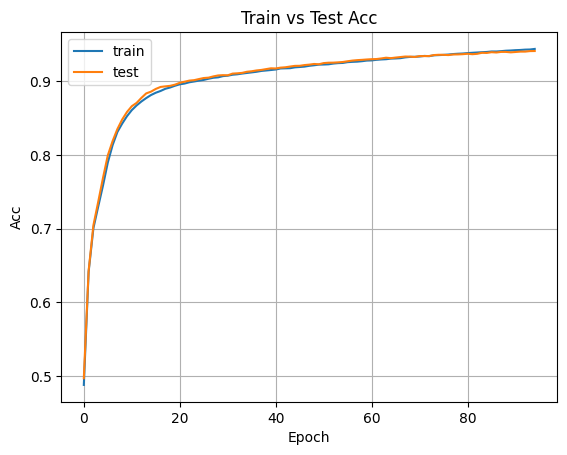

Epoch  96 | Loss:  186.593 | Train Acc:  0.945 | Test Acc:  0.942
Avg Loss:  0.199


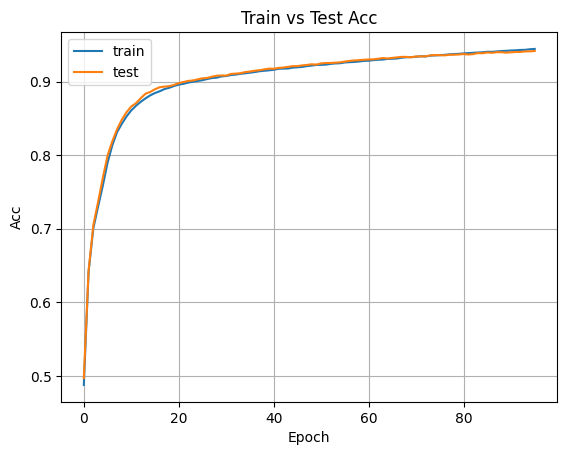

Epoch  97 | Loss:  185.393 | Train Acc:  0.945 | Test Acc:  0.942
Avg Loss:  0.198


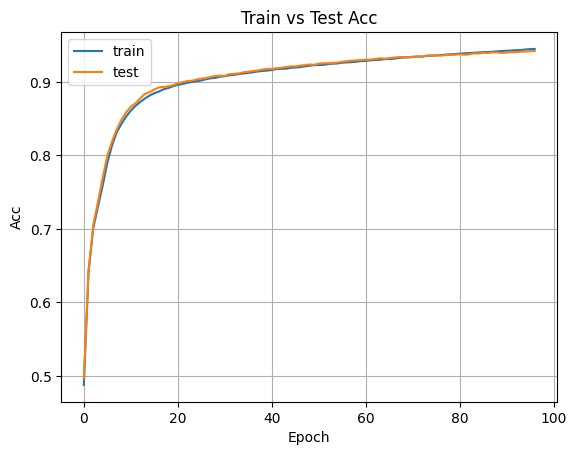

Epoch  98 | Loss:  184.124 | Train Acc:  0.945 | Test Acc:  0.942
Avg Loss:  0.196


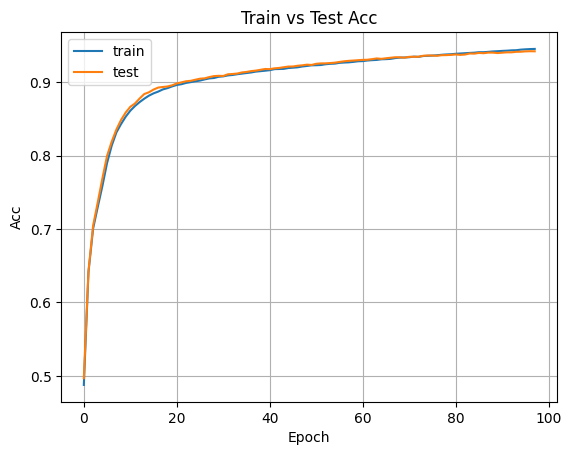

Epoch  99 | Loss:  183.045 | Train Acc:  0.946 | Test Acc:  0.943
Avg Loss:  0.195


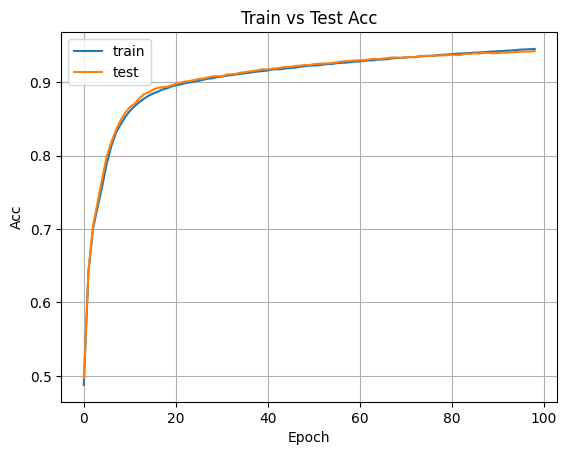

Epoch 100 | Loss:  181.802 | Train Acc:  0.946 | Test Acc:  0.943
Avg Loss:  0.194


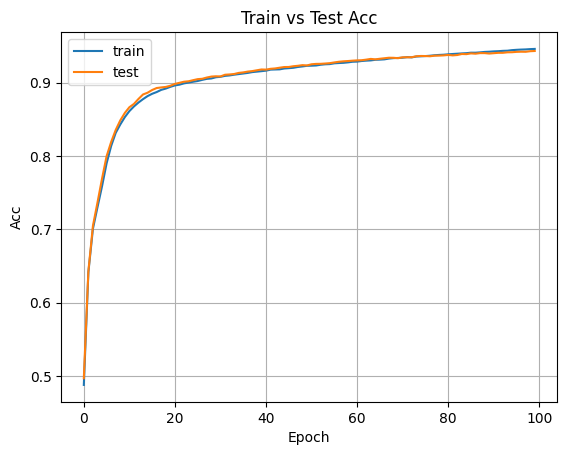

In [ ]:
n_epochs = 100
# 과제 - Cross Entropy Loss 함수 선언
loss_fn = nn.CrossEntropyLoss()

# 과제 - 학습/테스트 데이터 담을 곳
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.

  for inputs, labels in trainloader:
    model.zero_grad()
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # loss = (preds[:, 0] - labels).pow(2).mean() : 기존 MSE
    # 과제 - Cross Entropy Loss 적용
    loss = loss_fn(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    avg_loss = total_loss / len(trainloader)

  # 과제 - 정확도 측정
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  # 과제 - 정확도 데이터 담기
  train_accs.append(train_acc)
  test_accs.append(test_acc)

  # 정확도에 비해 Loss 값이 터무니 없이 크게 나옴
  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss: .3f} | Train Acc: {train_acc: .3f} | Test Acc: {test_acc: .3f}")
  print(f'Avg Loss: {avg_loss: .3f}')

  plot_acc(train_accs, test_accs)

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

train: tensor([[-0.9872, -4.4897, -0.7928,  0.5357, -1.0072,  1.5110, -7.5204,  9.2290,
         -0.2298,  5.8535]], device='cuda:0', grad_fn=<AddmmBackward0>) ans: 7
test: tensor([[ 3.2333, -8.0970,  5.5237, -3.9657,  1.6213,  1.7794, 13.5719, -7.7687,
         -0.4289, -3.8396]], device='cuda:0', grad_fn=<AddmmBackward0>) ans: 6


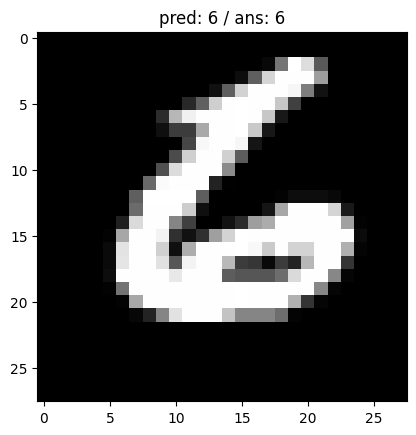

In [ ]:
idx = 9999

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

y = testset[idx][0][None]
y = y.to('cuda')

print(f'train: {model(x)} ans: {trainset[idx][1]}')
print(f'test: {model(y)} ans: {testset[idx][1]}')

# 실제 이미지랑 확인해보기
# plt.imshow(trainset[idx][0][0], cmap='gray')
# plt.title(f'pred: {torch.argmax(model(x), dim=1)} / ans: {trainset[idx][1]}')
plt.imshow(testset[idx][0][0], cmap='gray')

# 10차원 텐서에서 예측 클래스 찾기: argmax(model, dim)
# 찾은 1차원 예측 클래스 텐서의 값 뽑기: .item()
plt.title(f'pred: {torch.argmax(model(y), dim=1).item()} / ans: {testset[idx][1]}')
plt.show()

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.